In [1]:
import pandas as pd
import numpy as np
import optuna
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_circles

In [77]:
def weightInitialization(layerDims):
    """A helper function that initializes the weight and bias parameters to be used in the Neural Network
        Parameters:
        layerDims(list): An array-like structure whose length indicates the number of layers within the neural network
                         and each element in the array indicates the no. of dimensions, and therefore nodes, for the layer at that index
        Return:
        parameters(dict): A dictionary containing the values of the weight and bias parameters.
    """
    parameters = {}
    np.random.seed(31)
    for i in range(1, len(layerDims)):
        parameters['W'+str(i)] = np.random.randn(layerDims[i],layerDims[i-1])*np.sqrt(2./layerDims[i-1]) #shape = (layerDimsi, layerDimsi-1)
        parameters['b'+str(i)] = np.zeros((layerDims[i],1)) #shape = (layerDimsi,1)
        
    return parameters

In [78]:
#Activation functions
def sigmoid(z):
    return (1./(1. + np.exp(-z)))

def tanh(z):
    return (np.exp(z) - np.exp(-z))/(np.exp(z) + np.exp(-z))

def ReLU(z):
    #z = np.array(z,dtype ='float64')
    return  z*(z>0)

def leakyReLU(z):
    return np.maximum(0.01*z,z)

In [79]:
def forwardPropagation(X, parameters, activations, withDropout, keepProb):
    """A helper function that uses the weight and bias parameters to compute the output of each layer within the neural network.
        Parameters:
        X(np.array/pd.DataFrame): A matrix structure of shape(n_x, m) that serves as the input data to the Neural network.
                                  n_x represents the no. of dimensions/features while m represents the no. of observations/examples
        parameters(dict): A dictionary containing the weights and biases for the different layers
        activations(dict): A dictionary containing the activation functions used in each layer
        withDropout(list): An array of boolean values(represented as 1 or 0) indicating whether dropout is being applied to a particular layer in the Neural Network.
        keepProb(float): The dropout parameter representing the probability of keeping elements within a layer
        
        Return:
        forwardDict(dict): A dictionary containing the values of all the A and Z matrices computed throughout forward propagation
        L2Reg(list):A list containing all the frobenius norms of the weight parameters
        dropout(dict): A dictionary containing the 'dropout matrices' used in various layers of the Neural Network
    """
    A0 = X
    forwardDict = {'A0':A0}
    dropout = {}
    layers = len(parameters)//2
    L2Reg = []
    for i in range(1,layers  + 1):
        forwardDict['Z'+str(i)] = parameters['W' + str(i)].dot(forwardDict['A'+str(i-1)]) + parameters['b'+str(i)] #Zi = Wi.Ai-1 + bi; shape = (layerDimsi,m)
        if withDropout[i]:
            forwardDict['A'+str(i)] = activations[i](forwardDict['Z' + str(i)]) #Ai = gi(Zi); shape = (layerDimsi,m)
            dropout[i] = np.random.rand(forwardDict['A'+str(i)].shape[0],forwardDict['A'+str(i)].shape[1]) #creating a matrix of shape Ai with elements drawn from uniform dist. between 0 and 1
            dropout[i] = (dropout[i] < keepProb).astype(int) # approx. keepProb of the elements will be 1's the rest will be 0
            forwardDict['A' + str(i)] = forwardDict['A' + str(i)] * dropout[i] # this 'shuts down' elements in Ai for which the corresponding element in dropou[i] == 0
            forwardDict['A' + str(i)] = forwardDict['A' + str(i)] / keepProb #This ensures the expected mean of Ai does not change even after applying dropout
        else:
            forwardDict['A'+str(i)] = activations[i](forwardDict['Z'+str(i)]) #Ai = gi(Zi); shape = (layerDimsi,m)
        L2Reg.append(np.sum(np.square(parameters['W'+str(i)])))# frobenius norms
        
    return forwardDict, L2Reg, dropout

In [80]:
def logisticRegressionCost(Y, forwardDict, L2Reg,lambd, n):
    """A helper function that computes the logistic regression cost function
        Parameters:
        Y(np.array/pd.DataFrame): A matrix/vector structure of shape(n_y,m) that serves as the actual values for the response/target variable.
                                  n_y represents the dimension(s) of Y while m represents the number of observations/examples.
        forwardDict(dict): A dictionary containing the values of all A and Z matrices computed throughout forward propagation.
        L2Reg(list): A list containing all the frobenius norms of the weight parameters
        lambd(float): The parameter that determines how much the weights are penalized in L2 regularization
        n(int): An integer representing the index of the last layer
        
        Return:
        cost(float): A float representing the result from evaluating the logistic regression cost function between Y and the output of the last layer.
        dA_n(np.array): The partial derivative of the cost function w.r.t the last layer of the Neural Network
    """
    m = Y.shape[1]
    output = forwardDict['A'+str(n)]
    #print(output)
    cost = -(np.mean((Y*np.log(output) + (1.-Y)*(1.- np.log(output))), axis = 1, keepdims = True))
    cost += sum(L2Reg)*(lambd/(2*m))
    dA_n = (np.divide(1.-Y,1.-output) - np.divide(Y,output)) #The partial derivative of the cost function with respect to the last layer, output
    return cost, dA_n

In [6]:
#derivative of the activation functions
def sigmoidDerivative(z):
    return z*(1.-z)

def tanhDerivative(z):
    return 1. - np.square(z)

def ReLUDerivative(z):
    return (z > 0)*1.

def leakyReLUDerivative(z):
    return np.where(z > 0, 1., 0.01)

In [81]:
def backPropagation(forwardDict, parameters, derivatives,dA_n, m, lambd, dropout, keepProb): 
    """A helper function that performs backpropagation on the Neural Network.
        Parameters:
        forwardDict(dict): A dictionary containing all values of A and Z matrices computed throughout forward propagation.
        parameters(dict): A dictionary containing the weights and bias parameters for the layers in the neural network
        derivatives(dict): A dictionary containing the derivative of activation functions for each layer.
        dA_n(np.array): The partial derivative of the cost function with respect to the activation of the last layer in the neural network
        m(int): number of observations/examples in the input matrix.
        lambd(float): The parameter that determines how much the weights are penalized in L2 regularization
        dropout(dict): A dictionary containing the 'dropout matrices' used in various layers of the Neural Network
        keepProb(float): The dropout parameter representing the probability of keeping elements within a layer
        
        Return:
        gradients(dict): A dictionary containing the partial derivatives of the cost with respect to all of the A and Z matrices in the neural network.
    """
    layers = (len(forwardDict)-1)//2
    gradients = {'dA'+str(layers):dA_n}
    
    for i in range(layers,0,-1):
        gradients['dZ' + str(i)] = gradients['dA' + str(i)] * derivatives[i](forwardDict['Z' + str(i)])#dZi = dAi * gi'(Zi); shape = (layerDimsi,m)
        gradients['dW' + str(i)] = (1/m) * (gradients['dZ' + str(i)].dot(forwardDict['A' + str(i-1)].T)) + (lambd/m)*parameters['W'+str(i)] #dWi = dZi.Ai-1.T + lambd/m * Wi; shape = (layerDimsi, layerDimsi-1)
        gradients['db' + str(i)] = np.mean(gradients['dZ' + str(i)],axis = 1, keepdims = True) #dbi = mean(dZi); shape = (layerDimsi,1)
        gradients['dA' + str(i-1)] = parameters['W' + str(i)].T.dot(gradients['dZ' + str(i)])

        try: #The same dropout transformation that was applied in forward prop
            gradients['dA'+str(i-1)] = gradients['dA' + str(i-1)] * dropout[i-1] 
            gradients['dA'+str(i-1)] = gradients['dA'+str(i-1)] / keepProb
            
        except KeyError:
            continue
         
    return gradients

In [82]:
def updateParameters(parameters,gradients, v, s, learningRate, beta1, beta2, epsilon, optimizer, t): #expParams  instead of gradients
    """A helper function that updates the weights and biases in the neural networks using the partials from back propagation.
        Parameters:
        parameters(dict): A dictionary containing all the weights and bias parameters for layers in the neural network.
        gradients(dict): A dictionary containing all the partial derivatives of the cost w.r.t all fo the A and Z matrices in the neural network.
        learningRate(float): A float that determines the rate at which the weight parameters are updated.
        v(dict): A dictionary for containing exponentially weighted averages of the dW's and db's (gradient descent with momentum & Adam optimization)
        s(dict): A dictionary for containing exponentailly weighted averages of the dW's and db's(RMS Prop & Adam optimization)
        beta1(float): parameter for the v dictionary
        beta2(float): parameter for the s dictionary
        epsilon(float): parameter for Adam/RMS Prop optimization
        optimizer(string): A string representing which type of optimization should be performed when updating the weights/biases.
                            Values include 'gd' for minibatch gradient descent only, 'momentum' for gradient descent with momentum,
                            'Adam' for Adam optimization
        t(int): An integer representing what minibatch the model is currently processing
        
        Return:
        parameters(dict): The dictionary of weights and biases after they have been updated through gradient descent.
    """
    layers = len(parameters)//2
    for i in range(1, layers+1):
        v['dW' + str(i)] = beta1 * v['dW' + str(i)] + (1. - beta1) * gradients['dW' + str(i)]
        v['db' + str(i)] = beta1 * v['db' + str(i)] + (1. - beta1) * gradients['db' + str(i)]
        #v['dW' + str(i)] = np.divide(v['dW' + str(i)], (1. - beta1**t))
        #v['db' + str(i)] = np.divide(v['db' + str(i)], (1. - beta1**t))
        
        s['dW' + str(i)] = beta2 * s['dW' + str(i)] + (1. - beta2) * np.square(gradients['dW' + str(i)])
        s['db' + str(i)] = beta2 * s['db' + str(i)] + (1. - beta2) * np.square(gradients['db' + str(i)])
        #s['dW' + str(i)] = np.divide(s['dW' + str(i)], (1. - beta2**t))
        #s['db' + str(i)] = np.divide(s['db' + str(i)], (1. - beta2**t))
        
        if optimizer == 'gd':
            parameters['W' + str(i)] = parameters['W'+str(i)] - learningRate * gradients['dW'+str(i)]
            parameters['b' + str(i)] = parameters['b'+str(i)] - learningRate * gradients['db'+str(i)]
            
        elif optimizer == 'momentum':
            parameters['W' + str(i)] = parameters['W' + str(i)] - learningRate * v['dW' + str(i)]
            parameters['b' + str(i)] = parameters['b' + str(i)] - learningRate * v['db' + str(i)]
        else:
            parameters['W' + str(i)] = parameters['W' + str(i)] - learningRate * np.divide(v['dW' + str(i)],(np.sqrt(s['dW' + str(i)]) + epsilon))
            parameters['b' + str(i)] = parameters['b' + str(i)] - learningRate * np.divide(v['db' + str(i)],(np.sqrt(s['db' + str(i)]) + epsilon))

    return parameters

In [9]:
def deepNNRegularizedFit(X, Y, layerDims,activations, derivatives, withDropout, lambd = 0.,keepProb = 1., learningRate = 1e-1, epochs = 10000, batchSize = 64,
                        beta1 = 0.9, beta2 = 0.999, epsilon = 1e-8, optimizer = 'gd'):
    """Main function that fits the Neural network to the input data. Uses mini-batch gradient descent (with momentum) where appropriate
        Parameters:
        X(np.array/pd.DataFrame): A matrix structure of shape(n_x, m) that serves as the input data to the Neural network.
                                  n_x represents the no. of dimensions/features while m represents the no. of observations/examples
        Y(np.array/pd.DataFrame): A matrix/vector structure of shape(n_y,m) that serves as the actual values for the response/target variable.
                                  n_y represents the dimension(s) of Y while m represents the number of observations/examples.
        layerDims(list): An array-like structure whose length indicates the number of layers within the neural network
                         and each element in the array indicates the no. of dimensions, and therefore nodes, for the layer at that index.
        activations: A dictionary containing the activation functions used in each layer
        derivatives(dict): A dictionary containing the derivative of activation functions for each layer.
        lambd(float): The parameter that determines how much the weights are penalized in L2 regularization
        withDropout(list): An array of boolean values(represented as 1 or 0) indicating whether dropout is being applied to a particular layer in the Neural Network.
        keepProb(float): The dropout parameter representing the probability of keeping elements within a layer
        learningRate(float): A float that determines the rate at which the weight parameters are updated.
        epochs(int): An integer representing the number of iterations of forward prop, back prop and updates to be performed.
        batchSize(int): An integer representing the number of examples/observations in a single mini-batch of the input data
        beta1(float): parameter for the v dictionary
        beta2(float): parameter for the s dictionary
        epsilon(float): parameter for Adam/RMS Prop optimization
        optimizer(string): A string representing which type of optimization should be performed when updating the weights/biases.
                            Values include 'gd' for minibatch gradient descent only, 'momentum' for gradient descent with momentum,
                            'adam' for Adam optimization
        
        Return:
        parameters(dict): The final dictionary of weights and biases after they have been updated through gradient descent.
        costs(list): A list that contains the evaluation of the cost function after every 500 iterations
    """
    parameters = weightInitialization(layerDims) #initialize parameters
    costs = []# list to store costs
    m = X.shape[1]
    T = range(0,m,batchSize)
    v, s = {}, {} #dictionaries to store exp. weighted averages of partial derivatives of weights and biases for each layer
    for i in range(1, len(layerDims)):
        v['dW' + str(i)] = np.zeros((parameters['W' + str(i)].shape))
        v['db' + str(i)] = np.zeros((parameters['b' + str(i)].shape))
        s['dW' + str(i)] = np.zeros((parameters['W' + str(i)].shape))
        s['db' + str(i)] = np.zeros((parameters['b' + str(i)].shape))
        
    for _ in range(epochs):
        #Shuffle X and Y before generating minibatches
        permutation = list(np.random.permutation(m))
        Xshuffle = X[:,permutation]
        Yshuffle = Y[:,permutation]
        for i in range(len(T)):
            subX = Xshuffle[:,T[i]:T[i]+batchSize]
            subY = Yshuffle[:,T[i]:T[i]+batchSize]
            forwardDict, L2Reg, dropout = forwardPropagation(subX, parameters, activations, withDropout, keepProb)
            cost, dA_n = logisticRegressionCost(subY, forwardDict,L2Reg, lambd, n = len(layerDims)-1)
            if _%500 == 0 or _ == epochs -1 :
                costs.append(cost)
            gradients = backPropagation(forwardDict, parameters, derivatives, dA_n, m,lambd = lambd, dropout = dropout, keepProb = keepProb)
            parameters = updateParameters(parameters, gradients,v, s, learningRate, beta1, beta2, epsilon, optimizer, t = i+1) 
    
    return parameters, costs

def plotCosts(costs, learningRate, optimizer):
    """Function to plot the cost values during the training of the Neural Network.
        Parameters:
        costs(list): A list containing the cost after a constant number of iterations.
        learningRate(float): The learning rate value used in training the Neural Network
    """
    plt.figure(figsize = (8,6))
    plt.plot(np.squeeze(costs), lw = 2)
    plt.xlabel(' No. of epochs(x500)')
    plt.ylabel('Cost')
    plt.title(f'Learning Rate: {learningRate}, Optimization: {optimizer}')
    plt.show()
    

In [10]:
def deepNNPredict(X, parameters, activations):
    """Function that uses the parameters learned by the Neural Network to generate predictions of the response/target variable values.
        Parameters:
        X(np.array/pd.DataFrame): A matrix structure of shape(n_x, k) that serves as the input data to the Neural network.
                                  n_x represents the no. of dimensions/features while k represents the no. of observations/examples.
        parameters(dict): The final dictionary of weights and biases after they have been updated through gradient descent.
        activations: A dictionary containing the activation functions used in each layer.
        
        Return:
        YPred(np.array): A matrix structure of shape(n_y,k) that contains the Neural network's predictions for the target's values.
    """
    forwardDict, _, _ = forwardPropagation(X, parameters, activations, withDropout = [0]*(len(parameters)//2 + 1), keepProb = 1.)
    n = len(forwardDict)//2
    output = forwardDict['A'+str(n)]
    Ypred = np.where(output>=0.5,1,0)
    return Ypred

In [ ]:
#Dataset
make_circles?

In [11]:
examples = 3000
X,y = make_circles(n_samples = examples, shuffle= True, noise = 0.1,random_state = 3, factor = 0.6)

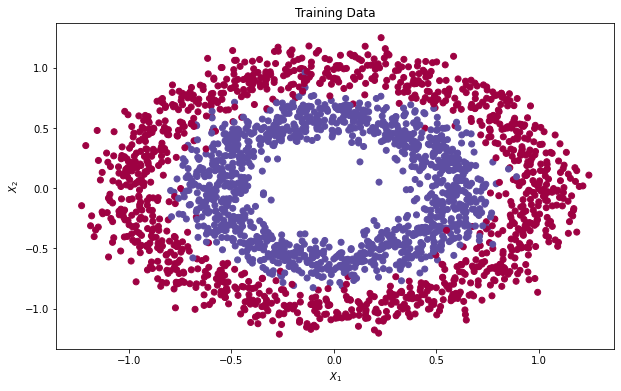

In [12]:
X_train,X_test, y_train, y_test = train_test_split(X,y.reshape(-1,1),test_size = 0.2,shuffle = True, random_state = 42)
X_train = X_train.T
X_test = X_test.T
y_train = y_train.T
y_test = y_test.T
plt.figure(figsize = (10,6))
plt.scatter(X_train[0,:],X_train[1,:],c = y_train, cmap = plt.cm.Spectral)
plt.xlabel('$X_1$')
plt.ylabel('$X_2$')
plt.title('Training Data')
plt.show()

In [13]:
#Predicting using the Neural Network constructed
#6 layers, ReLU for layer 1,2,3,4
#sigmoid for layer 5
#nodes per layer (2,2,4, 1)
layerDims = [2,19,2,9,4,1] #1,2,5,7,9,6,3,4
activationDict = {1: leakyReLU,2:leakyReLU,3:leakyReLU, 4:leakyReLU, 5:sigmoid}
derivativeDict = {1:leakyReLUDerivative, 2:leakyReLUDerivative,3:leakyReLUDerivative, 4:leakyReLUDerivative, 5:sigmoidDerivative}

In [14]:
def plotDecisionRegions(X,y,classifier,resolution=0.01):
    #set up marker generator and color map
    markers=('s','x','o','^','v')
    colors=('red','blue','lightgreen','gray','cyan')
    cmap=ListedColormap(colors[:len(np.unique(y))])
    
    #plot the decision surface
    x1_min, x1_max=X[0,:].min()-1, X[0,:].max()+1
    x2_min, x2_max=X[1,:].min()-1, X[1,:].max()+1
    xx1, xx2=np.meshgrid(np.arange(x1_min,x1_max,resolution),np.arange(x2_min,x2_max,resolution))
    Z=classifier(np.array([xx1.ravel(),xx2.ravel()]))
    Z=Z.reshape(xx2.shape)
    plt.figure(figsize=(10,6))
    plt.contourf(xx1,xx2,Z,alpha=0.3,cmap=cmap)
    
    #plot class examples
    for idx,cl in enumerate(np.unique(y)):
        k = y==cl
        plt.scatter(
                    X[0,k.ravel()],
                    X[1,k.ravel()],
                    alpha=0.8,
                    c=colors[idx],
                    marker=markers[idx],
                    label=cl,
                    facecolor='black')

In [16]:
X_train.shape

(2, 2400)

## i) No regularization, optimization: batch gradient descent

In [18]:
def objective(trial):
    alpha = trial.suggest_float('alpha',-9,-1)
    optimalParameters, costList = deepNNRegularizedFit(X_train, y_train, layerDims = layerDims ,activations = activationDict, derivatives = derivativeDict, withDropout = [0]*6, lambd = 0.,keepProb = 1., learningRate = 10**alpha, epochs = 5000, batchSize = X_train.shape[1], epsilon = 1e-8, optimizer = 'gd')
    y_train_pred = deepNNPredict(X_train, optimalParameters,activationDict)
    trainAccuracy = np.sum(y_train_pred == y_train)*(100/y_train.size)
    return trainAccuracy

In [20]:
study = optuna.create_study(direction = 'maximize')
study.optimize(objective, n_trials = 100)

[I 2024-04-23 15:52:37,670] A new study created in memory with name: no-name-1a074fca-6706-4001-b82d-31093ca765fb
C:\Users\user\AppData\Local\Temp/ipykernel_21568/3593828377.py:29: RuntimeWarning: overflow encountered in divide
  s['dW' + str(i)] = np.divide(s['dW' + str(i)], (1. - beta2**t))
C:\Users\user\AppData\Local\Temp/ipykernel_21568/3593828377.py:30: RuntimeWarning: overflow encountered in divide
  s['db' + str(i)] = np.divide(s['db' + str(i)], (1. - beta2**t))
C:\Users\user\AppData\Local\Temp/ipykernel_21568/3593828377.py:24: RuntimeWarning: overflow encountered in divide
  v['dW' + str(i)] = np.divide(v['dW' + str(i)], (1. - beta1**t))
C:\Users\user\AppData\Local\Temp/ipykernel_21568/3593828377.py:25: RuntimeWarning: overflow encountered in divide
  v['db' + str(i)] = np.divide(v['db' + str(i)], (1. - beta1**t))
[I 2024-04-23 15:52:49,865] Trial 0 finished with value: 52.45833333333333 and parameters: {'alpha': -3.8323717262868326}. Best is trial 0 with value: 52.458333333333

[I 2024-04-23 16:03:48,864] Trial 45 finished with value: 66.70833333333333 and parameters: {'alpha': -1.4231669112092948}. Best is trial 42 with value: 71.125.
[I 2024-04-23 16:04:04,521] Trial 46 finished with value: 68.83333333333333 and parameters: {'alpha': -1.004534251820013}. Best is trial 42 with value: 71.125.
[I 2024-04-23 16:04:19,823] Trial 47 finished with value: 65.70833333333333 and parameters: {'alpha': -1.7365896474349096}. Best is trial 42 with value: 71.125.
[I 2024-04-23 16:04:35,478] Trial 48 finished with value: 51.041666666666664 and parameters: {'alpha': -2.8238044415991235}. Best is trial 42 with value: 71.125.
[I 2024-04-23 16:04:50,900] Trial 49 finished with value: 49.625 and parameters: {'alpha': -8.134539807186275}. Best is trial 42 with value: 71.125.
[I 2024-04-23 16:05:06,131] Trial 50 finished with value: 59.541666666666664 and parameters: {'alpha': -3.4683686632787585}. Best is trial 42 with value: 71.125.
[I 2024-04-23 16:05:21,570] Trial 51 finished

[I 2024-04-23 16:16:28,062] Trial 95 finished with value: 66.79166666666666 and parameters: {'alpha': -1.3278122900262788}. Best is trial 64 with value: 71.20833333333333.
[I 2024-04-23 16:16:43,573] Trial 96 finished with value: 69.33333333333333 and parameters: {'alpha': -1.0341068798951527}. Best is trial 64 with value: 71.20833333333333.
[I 2024-04-23 16:16:58,589] Trial 97 finished with value: 67.20833333333333 and parameters: {'alpha': -1.1838268456821828}. Best is trial 64 with value: 71.20833333333333.
[I 2024-04-23 16:17:13,352] Trial 98 finished with value: 58.416666666666664 and parameters: {'alpha': -1.8860637673274447}. Best is trial 64 with value: 71.20833333333333.
[I 2024-04-23 16:17:28,194] Trial 99 finished with value: 66.625 and parameters: {'alpha': -1.4762329277147168}. Best is trial 64 with value: 71.20833333333333.


In [22]:
study.best_params

{'alpha': -1.0181021672956825}

### Training Set

In [23]:
optimalAlpha = -1.0181021672956825
optimalParameters, costList = deepNNRegularizedFit(X_train, y_train, layerDims = layerDims ,activations = activationDict, derivatives = derivativeDict, withDropout = [0]*6, lambd = 0.,keepProb = 1., learningRate = 10**optimalAlpha, epochs = 5000, batchSize = X_train.shape[1], epsilon = 1e-8, optimizer = 'gd')
y_train_pred = deepNNPredict(X_train, optimalParameters,activationDict)
trainAccuracy = np.sum(y_train_pred == y_train)*(100/y_train.size)

C:\Users\user\AppData\Local\Temp/ipykernel_21568/3593828377.py:29: RuntimeWarning: overflow encountered in divide
  s['dW' + str(i)] = np.divide(s['dW' + str(i)], (1. - beta2**t))
C:\Users\user\AppData\Local\Temp/ipykernel_21568/3593828377.py:30: RuntimeWarning: overflow encountered in divide
  s['db' + str(i)] = np.divide(s['db' + str(i)], (1. - beta2**t))
C:\Users\user\AppData\Local\Temp/ipykernel_21568/3593828377.py:24: RuntimeWarning: overflow encountered in divide
  v['dW' + str(i)] = np.divide(v['dW' + str(i)], (1. - beta1**t))
C:\Users\user\AppData\Local\Temp/ipykernel_21568/3593828377.py:25: RuntimeWarning: overflow encountered in divide
  v['db' + str(i)] = np.divide(v['db' + str(i)], (1. - beta1**t))


Training Accuracy: 71.20833333333333%


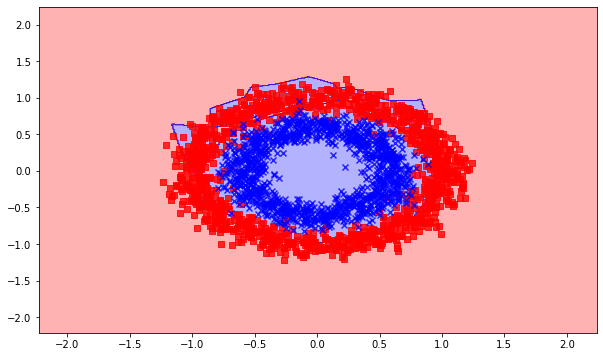

In [24]:
plotDecisionRegions(X_train, y_train, classifier = lambda x : deepNNPredict(x, optimalParameters, activationDict))
print(f'Training Accuracy: {trainAccuracy}%')

### Testing Set

In [25]:
y_test_pred = deepNNPredict(X_test, optimalParameters, activationDict)
testAccuracy = (np.sum(y_test == y_test_pred)/y_test.size)*100

Test set Accuracy: 70.16666666666667%


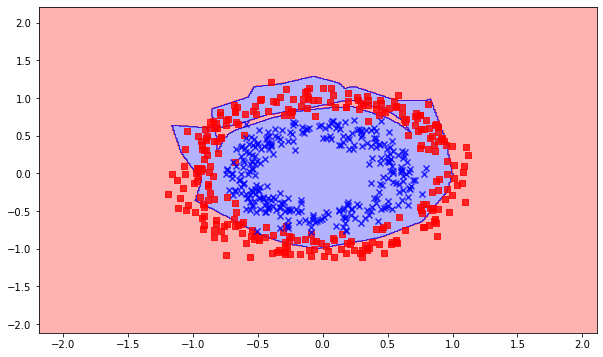

In [26]:
plotDecisionRegions(X_test, y_test, classifier = lambda x : deepNNPredict(x, optimalParameters, activationDict))
print(f'Test set Accuracy: {testAccuracy}%')

## ii) L2 regularization, optimization:  batch gradient descent 

In [27]:
def L2Objective(trial):
    alpha = trial.suggest_float('alpha',-9,-1)
    lambd = trial.suggest_float('lambd',0.,1.)
    optimalParameters, costList = deepNNRegularizedFit(X_train, y_train, layerDims = layerDims ,activations = activationDict, derivatives = derivativeDict, withDropout = [0]*6, lambd = lambd, keepProb = 1., learningRate = 10**alpha, epochs = 5000, batchSize = X_train.shape[1], epsilon = 1e-8, optimizer = 'gd')
    y_train_pred = deepNNPredict(X_train, optimalParameters,activationDict)
    trainAccuracy = np.sum(y_train_pred == y_train)*(100/y_train.size)
    return trainAccuracy

In [28]:
L2Study = optuna.create_study(direction = 'maximize')
L2Study.optimize(L2Objective, n_trials = 100)

[I 2024-04-23 16:29:44,706] A new study created in memory with name: no-name-999dcec5-4c13-48e5-9f6e-f59d09e5b5eb
C:\Users\user\AppData\Local\Temp/ipykernel_21568/3593828377.py:29: RuntimeWarning: overflow encountered in divide
  s['dW' + str(i)] = np.divide(s['dW' + str(i)], (1. - beta2**t))
C:\Users\user\AppData\Local\Temp/ipykernel_21568/3593828377.py:30: RuntimeWarning: overflow encountered in divide
  s['db' + str(i)] = np.divide(s['db' + str(i)], (1. - beta2**t))
C:\Users\user\AppData\Local\Temp/ipykernel_21568/3593828377.py:24: RuntimeWarning: overflow encountered in divide
  v['dW' + str(i)] = np.divide(v['dW' + str(i)], (1. - beta1**t))
C:\Users\user\AppData\Local\Temp/ipykernel_21568/3593828377.py:25: RuntimeWarning: overflow encountered in divide
  v['db' + str(i)] = np.divide(v['db' + str(i)], (1. - beta1**t))
[I 2024-04-23 16:30:00,585] Trial 0 finished with value: 54.291666666666664 and parameters: {'alpha': -3.1102772916699255, 'lambd': 0.29077712401714295}. Best is tria

[I 2024-04-23 16:39:48,350] Trial 38 finished with value: 65.20833333333333 and parameters: {'alpha': -1.7720705699695278, 'lambd': 0.41661617353715585}. Best is trial 33 with value: 72.70833333333333.
[I 2024-04-23 16:40:03,400] Trial 39 finished with value: 69.04166666666666 and parameters: {'alpha': -1.0350849773821877, 'lambd': 0.10137913337611493}. Best is trial 33 with value: 72.70833333333333.
[I 2024-04-23 16:40:18,426] Trial 40 finished with value: 49.625 and parameters: {'alpha': -5.56692436228306, 'lambd': 0.8471057387696144}. Best is trial 33 with value: 72.70833333333333.
[I 2024-04-23 16:40:35,857] Trial 41 finished with value: 73.79166666666666 and parameters: {'alpha': -1.0201578894238372, 'lambd': 0.9342615455420379}. Best is trial 41 with value: 73.79166666666666.
[I 2024-04-23 16:40:53,128] Trial 42 finished with value: 65.29166666666666 and parameters: {'alpha': -1.7632865807018874, 'lambd': 0.9100444675228988}. Best is trial 41 with value: 73.79166666666666.
[I 202

[I 2024-04-23 16:50:40,099] Trial 81 finished with value: 65.83333333333333 and parameters: {'alpha': -1.6010972752692765, 'lambd': 0.9321644189149484}. Best is trial 58 with value: 74.875.
[I 2024-04-23 16:50:54,972] Trial 82 finished with value: 66.83333333333333 and parameters: {'alpha': -1.1831372079084395, 'lambd': 0.8953218109250066}. Best is trial 58 with value: 74.875.
[I 2024-04-23 16:51:09,899] Trial 83 finished with value: 69.41666666666666 and parameters: {'alpha': -1.0438182683095463, 'lambd': 0.9804999946196462}. Best is trial 58 with value: 74.875.
[I 2024-04-23 16:51:24,774] Trial 84 finished with value: 65.79166666666666 and parameters: {'alpha': -1.7259893395312422, 'lambd': 0.7814780408116538}. Best is trial 58 with value: 74.875.
[I 2024-04-23 16:51:39,607] Trial 85 finished with value: 56.70833333333333 and parameters: {'alpha': -2.0183055958231613, 'lambd': 0.91497989957115}. Best is trial 58 with value: 74.875.
[I 2024-04-23 16:51:54,586] Trial 86 finished with v

In [29]:
L2Study.best_params

{'alpha': -1.0412320586610027, 'lambd': 0.8054622285904912}

### Train Set

In [31]:
optimalAlpha = -1.0412320586610027
optimalLambd = 0.8054622285904912
optimalParameters, costList = deepNNRegularizedFit(X_train, y_train, layerDims = layerDims ,activations = activationDict, derivatives = derivativeDict, withDropout = [0]*6, lambd = optimalLambd, keepProb = 1., learningRate = 10**optimalAlpha, epochs = 5000, batchSize = X_train.shape[1], epsilon = 1e-8, optimizer = 'gd')
y_train_pred = deepNNPredict(X_train, optimalParameters,activationDict)
trainAccuracy = np.sum(y_train_pred == y_train)*(100/y_train.size)

C:\Users\user\AppData\Local\Temp/ipykernel_21568/3593828377.py:29: RuntimeWarning: overflow encountered in divide
  s['dW' + str(i)] = np.divide(s['dW' + str(i)], (1. - beta2**t))
C:\Users\user\AppData\Local\Temp/ipykernel_21568/3593828377.py:30: RuntimeWarning: overflow encountered in divide
  s['db' + str(i)] = np.divide(s['db' + str(i)], (1. - beta2**t))
C:\Users\user\AppData\Local\Temp/ipykernel_21568/3593828377.py:24: RuntimeWarning: overflow encountered in divide
  v['dW' + str(i)] = np.divide(v['dW' + str(i)], (1. - beta1**t))
C:\Users\user\AppData\Local\Temp/ipykernel_21568/3593828377.py:25: RuntimeWarning: overflow encountered in divide
  v['db' + str(i)] = np.divide(v['db' + str(i)], (1. - beta1**t))


Training Accuracy: 74.875%


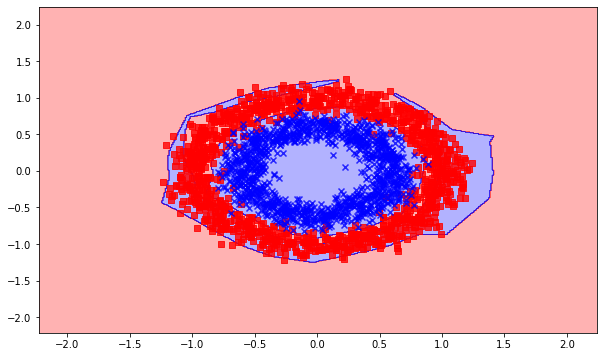

In [32]:
plotDecisionRegions(X_train, y_train, classifier = lambda x : deepNNPredict(x, optimalParameters, activationDict))
print(f'Training Accuracy: {trainAccuracy}%')

### Test Set

Test set Accuracy: 76.66666666666667%


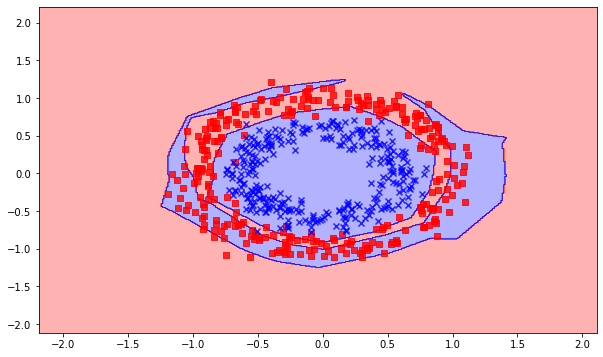

In [33]:
y_test_pred = deepNNPredict(X_test, optimalParameters, activationDict)
testAccuracy = (np.sum(y_test == y_test_pred)/y_test.size)*100
plotDecisionRegions(X_test, y_test, classifier = lambda x : deepNNPredict(x, optimalParameters, activationDict))
print(f'Test set Accuracy: {testAccuracy}%')

## iii) Dropout regularization, optimization: batch gradient descent

Introducing dropout in the first and third hidden layers of the neural network

In [42]:
def dropoutObjective(trial):
    alpha = trial.suggest_float('alpha', -9, -1)
    keepProb = trial.suggest_float('keepProb', 0.4, 1.0)
    optimalParameters, costList = deepNNRegularizedFit(X_train, y_train, layerDims = layerDims ,activations = activationDict, derivatives = derivativeDict, withDropout = [0,1,0,1,0,0], keepProb = keepProb, learningRate = 10**alpha, epochs = 5000, batchSize = X_train.shape[1], epsilon = 1e-8, optimizer = 'gd')
    y_train_pred = deepNNPredict(X_train, optimalParameters,activationDict)
    trainAccuracy = np.sum(y_train_pred == y_train)*(100/y_train.size)
    return trainAccuracy

In [43]:
dropoutStudy = optuna.create_study(direction = 'maximize')
dropoutStudy.optimize(dropoutObjective, n_trials = 100)

[I 2024-04-23 18:30:56,989] A new study created in memory with name: no-name-4f60fe20-2935-4506-a690-0b4e5528c211
C:\Users\user\AppData\Local\Temp/ipykernel_21568/275497014.py:3: RuntimeWarning: overflow encountered in exp
  return (1./(1. + np.exp(-z)))
C:\Users\user\AppData\Local\Temp/ipykernel_21568/807989192.py:18: RuntimeWarning: divide by zero encountered in log
  cost = -(np.mean((Y*np.log(output) + (1.-Y)*(1.- np.log(output))), axis = 1, keepdims = True))
C:\Users\user\AppData\Local\Temp/ipykernel_21568/807989192.py:18: RuntimeWarning: invalid value encountered in multiply
  cost = -(np.mean((Y*np.log(output) + (1.-Y)*(1.- np.log(output))), axis = 1, keepdims = True))
C:\Users\user\AppData\Local\Temp/ipykernel_21568/807989192.py:20: RuntimeWarning: divide by zero encountered in divide
  dA_n = (np.divide(1.-Y,1.-output) - np.divide(Y,output)) #The partial derivative of the cost function with respect to the last layer, output
C:\Users\user\AppData\Local\Temp/ipykernel_21568/8079

[I 2024-04-23 18:39:51,258] Trial 30 finished with value: 50.33333333333333 and parameters: {'alpha': -4.4077616736601515, 'keepProb': 0.8304486147639785}. Best is trial 25 with value: 54.375.
[I 2024-04-23 18:40:08,769] Trial 31 finished with value: 49.83333333333333 and parameters: {'alpha': -2.48426737162184, 'keepProb': 0.9929523093666034}. Best is trial 25 with value: 54.375.
[I 2024-04-23 18:40:25,938] Trial 32 finished with value: 52.625 and parameters: {'alpha': -1.6810339537639694, 'keepProb': 0.9535902738800863}. Best is trial 25 with value: 54.375.
[I 2024-04-23 18:40:43,015] Trial 33 finished with value: 52.666666666666664 and parameters: {'alpha': -1.5879718827752662, 'keepProb': 0.9366466647516679}. Best is trial 25 with value: 54.375.
[I 2024-04-23 18:41:00,112] Trial 34 finished with value: 50.041666666666664 and parameters: {'alpha': -1.5830860943454113, 'keepProb': 0.8912989211394801}. Best is trial 25 with value: 54.375.
[I 2024-04-23 18:41:17,135] Trial 35 finished 

[I 2024-04-23 18:51:38,381] Trial 72 finished with value: 65.54166666666666 and parameters: {'alpha': -1.5561492127658956, 'keepProb': 0.9989367319076241}. Best is trial 63 with value: 79.25.
[I 2024-04-23 18:51:55,022] Trial 73 finished with value: 49.625 and parameters: {'alpha': -8.983033622326712, 'keepProb': 0.9946499465427716}. Best is trial 63 with value: 79.25.
[I 2024-04-23 18:52:11,712] Trial 74 finished with value: 57.45833333333333 and parameters: {'alpha': -1.9714330136968345, 'keepProb': 0.9989344741223556}. Best is trial 63 with value: 79.25.
[I 2024-04-23 18:52:28,161] Trial 75 finished with value: 51.70833333333333 and parameters: {'alpha': -1.6778757125851125, 'keepProb': 0.9432458208184961}. Best is trial 63 with value: 79.25.
[I 2024-04-23 18:52:44,692] Trial 76 finished with value: 49.791666666666664 and parameters: {'alpha': -2.313622487228418, 'keepProb': 0.9838161538799494}. Best is trial 63 with value: 79.25.
[I 2024-04-23 18:53:01,013] Trial 77 finished with v

In [44]:
dropoutStudy.best_params

{'alpha': -1.0492987615930298, 'keepProb': 0.9990423621176738}

In [47]:
optimalAlpha = -1.0492987615930298
optimalKeepProb = 0.9990423621176738
optimalParameters, costList = deepNNRegularizedFit(X_train, y_train, layerDims = layerDims ,activations = activationDict, derivatives = derivativeDict, withDropout = [0,1,0,1,0,0],keepProb = optimalKeepProb, learningRate = 10**optimalAlpha, epochs = 5000, batchSize = X_train.shape[1], epsilon = 1e-8, optimizer = 'gd')
y_train_pred = deepNNPredict(X_train, optimalParameters,activationDict) #dropout is only applied in training, not in validation or test phase
trainAccuracy = np.sum(y_train_pred == y_train)*(100/y_train.size)

C:\Users\user\AppData\Local\Temp/ipykernel_21568/3593828377.py:29: RuntimeWarning: overflow encountered in divide
  s['dW' + str(i)] = np.divide(s['dW' + str(i)], (1. - beta2**t))
C:\Users\user\AppData\Local\Temp/ipykernel_21568/3593828377.py:30: RuntimeWarning: overflow encountered in divide
  s['db' + str(i)] = np.divide(s['db' + str(i)], (1. - beta2**t))
C:\Users\user\AppData\Local\Temp/ipykernel_21568/3593828377.py:24: RuntimeWarning: overflow encountered in divide
  v['dW' + str(i)] = np.divide(v['dW' + str(i)], (1. - beta1**t))
C:\Users\user\AppData\Local\Temp/ipykernel_21568/3593828377.py:25: RuntimeWarning: overflow encountered in divide
  v['db' + str(i)] = np.divide(v['db' + str(i)], (1. - beta1**t))


Training Accuracy: 79.25%


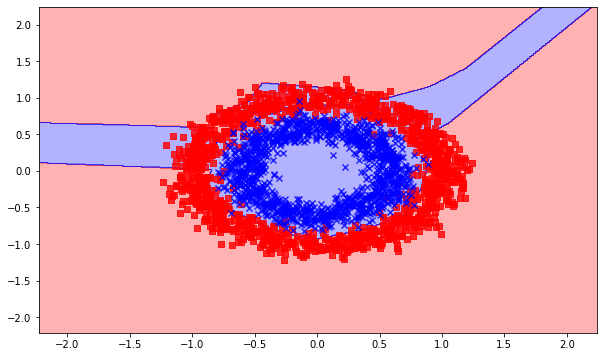

In [48]:
plotDecisionRegions(X_train, y_train, classifier = lambda x : deepNNPredict(x, optimalParameters, activationDict))
print(f'Training Accuracy: {trainAccuracy}%')

Test set Accuracy: 77.16666666666666%


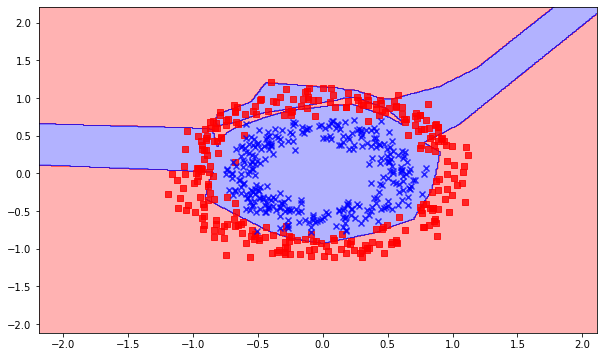

In [49]:
y_test_pred = deepNNPredict(X_test, optimalParameters, activationDict)
testAccuracy = (np.sum(y_test == y_test_pred)/y_test.size)*100
plotDecisionRegions(X_test, y_test, classifier = lambda x : deepNNPredict(x, optimalParameters, activationDict))
print(f'Test set Accuracy: {testAccuracy}%')

## iv) Optmization: Minibatch Gradient Descent

In [50]:
def minibatchObjective(trial):
    alpha = trial.suggest_float('alpha', -9, -1)
    batchSize = trial.suggest_categorical('batchSize', [64, 128, 256])
    optimalParameters, costList = deepNNRegularizedFit(X_train, y_train, layerDims = layerDims ,activations = activationDict, derivatives = derivativeDict, withDropout = [0,0,0,0,0,0], learningRate = 10**alpha, epochs = 5000, batchSize = batchSize, epsilon = 1e-8, optimizer = 'gd')
    y_train_pred = deepNNPredict(X_train, optimalParameters,activationDict)
    trainAccuracy = np.sum(y_train_pred == y_train)*(100/y_train.size)
    return trainAccuracy

In [51]:
minibatchStudy = optuna.create_study(direction = 'maximize')
minibatchStudy.optimize(minibatchObjective, n_trials = 100)

[I 2024-04-23 19:20:39,880] A new study created in memory with name: no-name-d28fff6f-a7d0-4d2f-8677-d2986edd0e6e
C:\Users\user\AppData\Local\Temp/ipykernel_21568/3593828377.py:30: RuntimeWarning: overflow encountered in divide
  s['db' + str(i)] = np.divide(s['db' + str(i)], (1. - beta2**t))
C:\Users\user\AppData\Local\Temp/ipykernel_21568/3593828377.py:29: RuntimeWarning: overflow encountered in divide
  s['dW' + str(i)] = np.divide(s['dW' + str(i)], (1. - beta2**t))
C:\Users\user\AppData\Local\Temp/ipykernel_21568/3593828377.py:25: RuntimeWarning: overflow encountered in divide
  v['db' + str(i)] = np.divide(v['db' + str(i)], (1. - beta1**t))
C:\Users\user\AppData\Local\Temp/ipykernel_21568/3593828377.py:24: RuntimeWarning: overflow encountered in divide
  v['dW' + str(i)] = np.divide(v['dW' + str(i)], (1. - beta1**t))
[I 2024-04-23 19:21:38,726] Trial 0 finished with value: 49.625 and parameters: {'alpha': -6.556475190384765, 'batchSize': 128}. Best is trial 0 with value: 49.625.
[

[I 2024-04-23 20:07:12,165] Trial 41 finished with value: 86.125 and parameters: {'alpha': -1.2719892701420141, 'batchSize': 128}. Best is trial 1 with value: 86.41666666666666.
[I 2024-04-23 20:08:11,708] Trial 42 finished with value: 81.45833333333333 and parameters: {'alpha': -1.4753890312163782, 'batchSize': 128}. Best is trial 1 with value: 86.41666666666666.
[I 2024-04-23 20:09:10,896] Trial 43 finished with value: 87.375 and parameters: {'alpha': -1.3295209016242866, 'batchSize': 128}. Best is trial 43 with value: 87.375.
[I 2024-04-23 20:10:09,908] Trial 44 finished with value: 69.58333333333333 and parameters: {'alpha': -1.8510715246773124, 'batchSize': 128}. Best is trial 43 with value: 87.375.
[I 2024-04-23 20:11:08,510] Trial 45 finished with value: 86.83333333333333 and parameters: {'alpha': -1.3574561105356933, 'batchSize': 128}. Best is trial 43 with value: 87.375.
[I 2024-04-23 20:12:05,820] Trial 46 finished with value: 57.5 and parameters: {'alpha': -2.380842184395481

[I 2024-04-23 20:54:30,670] Trial 87 finished with value: 79.95833333333333 and parameters: {'alpha': -1.5025270100847443, 'batchSize': 128}. Best is trial 64 with value: 88.08333333333333.
[I 2024-04-23 20:55:45,222] Trial 88 finished with value: 85.54166666666666 and parameters: {'alpha': -1.256445960970811, 'batchSize': 128}. Best is trial 64 with value: 88.08333333333333.
[I 2024-04-23 20:56:59,645] Trial 89 finished with value: 69.58333333333333 and parameters: {'alpha': -1.851090201299, 'batchSize': 128}. Best is trial 64 with value: 88.08333333333333.
[I 2024-04-23 20:57:44,358] Trial 90 finished with value: 73.875 and parameters: {'alpha': -1.5710907076538205, 'batchSize': 256}. Best is trial 64 with value: 88.08333333333333.
[I 2024-04-23 20:59:02,635] Trial 91 finished with value: 86.125 and parameters: {'alpha': -1.2924827803361005, 'batchSize': 128}. Best is trial 64 with value: 88.08333333333333.
[I 2024-04-23 21:00:20,676] Trial 92 finished with value: 85.5 and parameters

In [52]:
minibatchStudy.best_params

{'alpha': -1.2450743830209996, 'batchSize': 128}

C:\Users\user\AppData\Local\Temp/ipykernel_21568/3593828377.py:30: RuntimeWarning: overflow encountered in divide
  s['db' + str(i)] = np.divide(s['db' + str(i)], (1. - beta2**t))
C:\Users\user\AppData\Local\Temp/ipykernel_21568/3593828377.py:29: RuntimeWarning: overflow encountered in divide
  s['dW' + str(i)] = np.divide(s['dW' + str(i)], (1. - beta2**t))
C:\Users\user\AppData\Local\Temp/ipykernel_21568/3593828377.py:25: RuntimeWarning: overflow encountered in divide
  v['db' + str(i)] = np.divide(v['db' + str(i)], (1. - beta1**t))
C:\Users\user\AppData\Local\Temp/ipykernel_21568/3593828377.py:24: RuntimeWarning: overflow encountered in divide
  v['dW' + str(i)] = np.divide(v['dW' + str(i)], (1. - beta1**t))


Training Accuracy: 88.08333333333333%


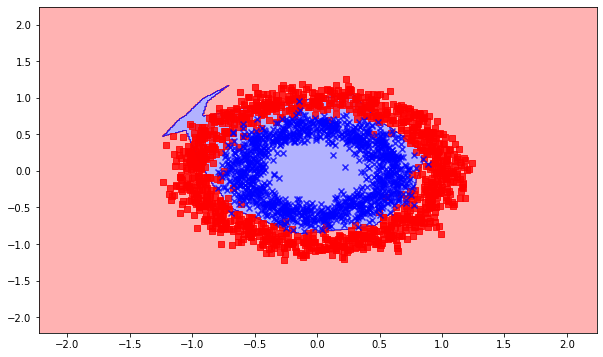

In [53]:
optimalAlpha =  -1.2450743830209996
optimalBatchSize = 128
optimalParameters, costList = deepNNRegularizedFit(X_train, y_train, layerDims = layerDims ,activations = activationDict, derivatives = derivativeDict, withDropout = [0]*6, learningRate = 10**optimalAlpha, epochs = 5000, batchSize = optimalBatchSize,epsilon = 1e-8, optimizer = 'gd')
y_train_pred = deepNNPredict(X_train, optimalParameters,activationDict)
trainAccuracy = np.sum(y_train_pred == y_train)*(100/y_train.size)
plotDecisionRegions(X_train, y_train, classifier = lambda x : deepNNPredict(x, optimalParameters, activationDict))
print(f'Training Accuracy: {trainAccuracy}%')

Test set Accuracy: 86.83333333333333%


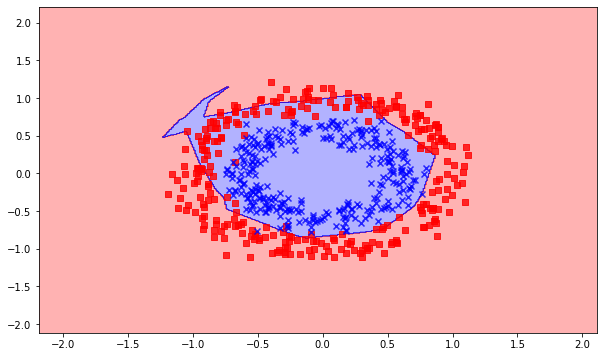

In [54]:
y_test_pred = deepNNPredict(X_test, optimalParameters, activationDict)
testAccuracy = (np.sum(y_test == y_test_pred)/y_test.size)*100
plotDecisionRegions(X_test, y_test, classifier = lambda x : deepNNPredict(x, optimalParameters, activationDict))
print(f'Test set Accuracy: {testAccuracy}%')

## v) L2 Regularization, optimization: minibatch gradient descent

In [55]:
def minibatchL2Objective(trial):
    alpha = trial.suggest_float('alpha',-9,-1)
    lambd = trial.suggest_float('lambd',0.,1.)
    batchSize = trial.suggest_categorical('batchSize',[64,128])
    optimalParameters, costList = deepNNRegularizedFit(X_train, y_train, layerDims = layerDims, activations = activationDict, derivatives = derivativeDict, withDropout = [0]*6, lambd = lambd, keepProb = 1., learningRate = 10**alpha, epochs = 5000, batchSize = batchSize, epsilon = 1e-8, optimizer = 'gd')
    y_train_pred = deepNNPredict(X_train, optimalParameters,activationDict)
    trainAccuracy = np.sum(y_train_pred == y_train)*(100/y_train.size)
    return trainAccuracy

### Training set

In [57]:
minibatchL2Study = optuna.create_study(direction = 'maximize')
minibatchL2Study.optimize(minibatchL2Objective, n_trials = 100)

[I 2024-04-24 09:00:16,561] A new study created in memory with name: no-name-b492ca07-3bd3-42f9-a9b6-4695cda9d146
C:\Users\user\AppData\Local\Temp/ipykernel_21568/3593828377.py:30: RuntimeWarning: overflow encountered in divide
  s['db' + str(i)] = np.divide(s['db' + str(i)], (1. - beta2**t))
C:\Users\user\AppData\Local\Temp/ipykernel_21568/3593828377.py:29: RuntimeWarning: overflow encountered in divide
  s['dW' + str(i)] = np.divide(s['dW' + str(i)], (1. - beta2**t))
C:\Users\user\AppData\Local\Temp/ipykernel_21568/3593828377.py:25: RuntimeWarning: overflow encountered in divide
  v['db' + str(i)] = np.divide(v['db' + str(i)], (1. - beta1**t))
C:\Users\user\AppData\Local\Temp/ipykernel_21568/3593828377.py:24: RuntimeWarning: overflow encountered in divide
  v['dW' + str(i)] = np.divide(v['dW' + str(i)], (1. - beta1**t))
[I 2024-04-24 09:01:40,961] Trial 0 finished with value: 53.916666666666664 and parameters: {'alpha': -4.248270164248733, 'lambd': 0.9472329317935201, 'batchSize': 12

[I 2024-04-24 10:02:49,009] Trial 36 finished with value: 53.25 and parameters: {'alpha': -4.144221501441448, 'lambd': 0.14893016676267448, 'batchSize': 128}. Best is trial 25 with value: 83.70833333333333.
[I 2024-04-24 10:03:45,703] Trial 37 finished with value: 55.916666666666664 and parameters: {'alpha': -2.54239912329827, 'lambd': 0.06168800435368313, 'batchSize': 128}. Best is trial 25 with value: 83.70833333333333.
[I 2024-04-24 10:04:43,796] Trial 38 finished with value: 68.08333333333333 and parameters: {'alpha': -2.0716395073743126, 'lambd': 0.24783475268274507, 'batchSize': 128}. Best is trial 25 with value: 83.70833333333333.
[I 2024-04-24 10:05:41,450] Trial 39 finished with value: 77.875 and parameters: {'alpha': -1.2376545663414888, 'lambd': 0.05016699218456174, 'batchSize': 128}. Best is trial 25 with value: 83.70833333333333.
[I 2024-04-24 10:06:46,480] Trial 40 finished with value: 53.95833333333333 and parameters: {'alpha': -1.0013656769868273, 'lambd': 0.99015167149

[I 2024-04-24 11:01:09,158] Trial 75 finished with value: 84.29166666666666 and parameters: {'alpha': -1.0656975304165297, 'lambd': 0.08344819369253081, 'batchSize': 128}. Best is trial 52 with value: 86.04166666666666.
[I 2024-04-24 11:02:06,967] Trial 76 finished with value: 86.25 and parameters: {'alpha': -1.0087942790291482, 'lambd': 0.06890280425402515, 'batchSize': 128}. Best is trial 76 with value: 86.25.
[I 2024-04-24 11:03:03,653] Trial 77 finished with value: 87.20833333333333 and parameters: {'alpha': -1.0348689505759627, 'lambd': 0.07433420173557057, 'batchSize': 128}. Best is trial 77 with value: 87.20833333333333.
[I 2024-04-24 11:04:00,264] Trial 78 finished with value: 69.875 and parameters: {'alpha': -1.6089834698250387, 'lambd': 0.2103072679022518, 'batchSize': 128}. Best is trial 77 with value: 87.20833333333333.
[I 2024-04-24 11:04:57,568] Trial 79 finished with value: 68.41666666666666 and parameters: {'alpha': -2.0296299764826884, 'lambd': 0.15323917047679808, 'ba

In [58]:
minibatchL2Study.best_params

{'alpha': -1.0033669779751964, 'lambd': 0.03912862459900081, 'batchSize': 128}

C:\Users\user\AppData\Local\Temp/ipykernel_21568/3593828377.py:30: RuntimeWarning: overflow encountered in divide
  s['db' + str(i)] = np.divide(s['db' + str(i)], (1. - beta2**t))
C:\Users\user\AppData\Local\Temp/ipykernel_21568/3593828377.py:29: RuntimeWarning: overflow encountered in divide
  s['dW' + str(i)] = np.divide(s['dW' + str(i)], (1. - beta2**t))
C:\Users\user\AppData\Local\Temp/ipykernel_21568/3593828377.py:25: RuntimeWarning: overflow encountered in divide
  v['db' + str(i)] = np.divide(v['db' + str(i)], (1. - beta1**t))
C:\Users\user\AppData\Local\Temp/ipykernel_21568/3593828377.py:24: RuntimeWarning: overflow encountered in divide
  v['dW' + str(i)] = np.divide(v['dW' + str(i)], (1. - beta1**t))


Train set Accuracy:88.0


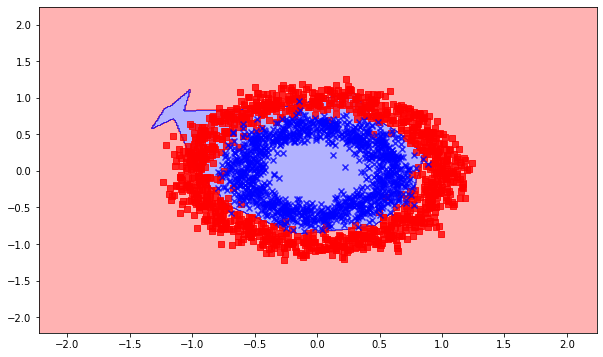

In [59]:
optimalAlpha = -1.0033669779751964
optimalLambd = 0.03912862459900081
optimalBatchSize = 128
optimalParameters, costList = deepNNRegularizedFit(X_train, y_train, layerDims = layerDims, activations = activationDict, derivatives = derivativeDict, withDropout = [0]*6, lambd = optimalLambd, keepProb = 1., learningRate = 10**optimalAlpha, epochs = 5000, batchSize = optimalBatchSize, epsilon = 1e-8, optimizer = 'gd')
y_train_pred = deepNNPredict(X_train, optimalParameters,activationDict)
trainAccuracy = np.sum(y_train_pred == y_train)*(100/y_train.size)
plotDecisionRegions(X_train, y_train, classifier = lambda x : deepNNPredict(x, optimalParameters, activationDict))
print(f'Train set Accuracy:{trainAccuracy}')

### Test set

Testing Accuracy:86.16666666666667


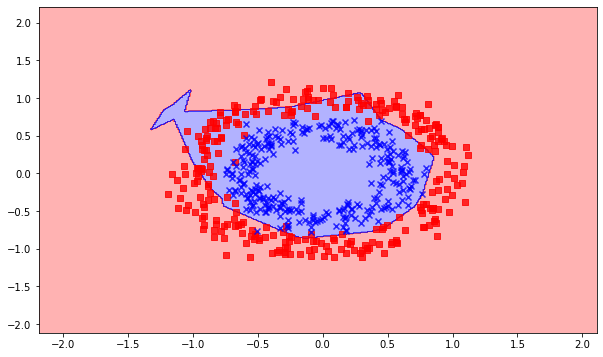

In [61]:
y_test_pred = deepNNPredict(X_test, optimalParameters, activationDict)
testAccuracy = (np.sum(y_test == y_test_pred)/y_test.size)*100
plotDecisionRegions(X_test, y_test, classifier = lambda x : deepNNPredict(x, optimalParameters, activationDict))
print(f'Testing Accuracy:{testAccuracy}')

## vi) Optimization: Minibatch gradient descent with momentum

In [94]:
def momentumObjective(trial):
    alpha = trial.suggest_float('alpha',-4,-1)
    beta1 = trial.suggest_float('beta1',0.89,1.)
    batchSize = trial.suggest_categorical('batchSize',[64,128])
    optimalParameters, costList = deepNNRegularizedFit(X_train, y_train, layerDims = layerDims, activations = activationDict, derivatives = derivativeDict, withDropout = [0]*6, keepProb = 1., learningRate = 10**alpha, epochs = 5000, batchSize = batchSize, beta1 = beta1, epsilon = 1e-8, optimizer = 'momentum')
    y_train_pred = deepNNPredict(X_train, optimalParameters,activationDict)
    trainAccuracy = np.sum(y_train_pred == y_train)*(100/y_train.size)
    return trainAccuracy

In [95]:
momentumStudy = optuna.create_study(direction = 'maximize')
momentumStudy.optimize(momentumObjective, n_trials = 50)

[I 2024-04-25 00:31:49,476] A new study created in memory with name: no-name-534a1a46-da8d-46f8-a97a-17afcf2b7438
[I 2024-04-25 00:32:55,176] Trial 0 finished with value: 73.33333333333333 and parameters: {'alpha': -1.3066388764467134, 'beta1': 0.9939691096848676, 'batchSize': 128}. Best is trial 0 with value: 73.33333333333333.
[I 2024-04-25 00:34:55,921] Trial 1 finished with value: 53.25 and parameters: {'alpha': -2.878541722924238, 'beta1': 0.9104622802524323, 'batchSize': 64}. Best is trial 0 with value: 73.33333333333333.
[I 2024-04-25 00:36:02,095] Trial 2 finished with value: 67.75 and parameters: {'alpha': -1.6494006546791016, 'beta1': 0.9390637245267861, 'batchSize': 128}. Best is trial 0 with value: 73.33333333333333.
[I 2024-04-25 00:38:04,949] Trial 3 finished with value: 50.375 and parameters: {'alpha': -3.4938927368275707, 'beta1': 0.9108113797199408, 'batchSize': 64}. Best is trial 0 with value: 73.33333333333333.
[I 2024-04-25 00:39:11,982] Trial 4 finished with value:

[I 2024-04-25 01:22:54,414] Trial 36 finished with value: 88.95833333333333 and parameters: {'alpha': -1.3670767344706587, 'beta1': 0.9129042091124444, 'batchSize': 64}. Best is trial 8 with value: 94.08333333333333.
[I 2024-04-25 01:24:58,920] Trial 37 finished with value: 60.541666666666664 and parameters: {'alpha': -1.203625158238427, 'beta1': 0.9048396695468367, 'batchSize': 64}. Best is trial 8 with value: 94.08333333333333.
[I 2024-04-25 01:27:05,778] Trial 38 finished with value: 68.125 and parameters: {'alpha': -2.1974063323278097, 'beta1': 0.9174426181137227, 'batchSize': 64}. Best is trial 8 with value: 94.08333333333333.
[I 2024-04-25 01:29:41,372] Trial 39 finished with value: 71.875 and parameters: {'alpha': -1.6384875720349488, 'beta1': 0.9131929618664619, 'batchSize': 64}. Best is trial 8 with value: 94.08333333333333.
[I 2024-04-25 01:32:23,185] Trial 40 finished with value: 83.875 and parameters: {'alpha': -1.3829426500342499, 'beta1': 0.9019015464209423, 'batchSize': 

### Train Set

In [96]:
momentumStudy.best_trial

FrozenTrial(number=8, state=TrialState.COMPLETE, values=[94.08333333333333], datetime_start=datetime.datetime(2024, 4, 25, 0, 42, 35, 819936), datetime_complete=datetime.datetime(2024, 4, 25, 0, 43, 46, 671581), params={'alpha': -1.0602895497460176, 'beta1': 0.9815987436488792, 'batchSize': 128}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'alpha': FloatDistribution(high=-1.0, log=False, low=-4.0, step=None), 'beta1': FloatDistribution(high=1.0, log=False, low=0.89, step=None), 'batchSize': CategoricalDistribution(choices=(64, 128))}, trial_id=8, value=None)

In [97]:
momentumStudy.best_params

{'alpha': -1.0602895497460176, 'beta1': 0.9815987436488792, 'batchSize': 128}

By trial 8, an accuracy of 94.08 had already been obtained!

Train set Accuracy:94.08333333333333


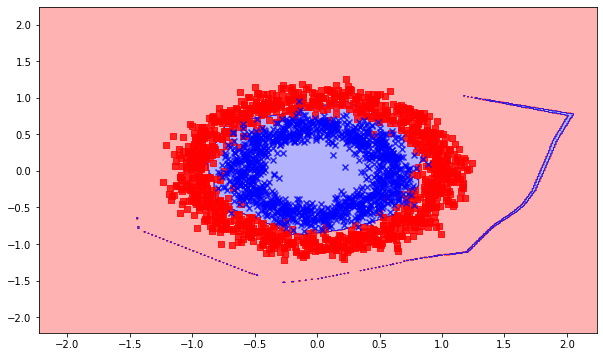

In [98]:
optimalAlpha = -1.0602895497460176
optimalBeta1 = 0.9815987436488792
optimalBatchSize = 128
optimalParameters, costList = deepNNRegularizedFit(X_train, y_train, layerDims = layerDims, activations = activationDict, derivatives = derivativeDict, withDropout = [0]*6, keepProb = 1., learningRate = 10**optimalAlpha, epochs = 5000, batchSize = optimalBatchSize, beta1 = optimalBeta1, epsilon = 1e-8, optimizer = 'momentum')
y_train_pred = deepNNPredict(X_train, optimalParameters,activationDict)
trainAccuracy = np.sum(y_train_pred == y_train)*(100/y_train.size)
plotDecisionRegions(X_train, y_train, classifier = lambda x : deepNNPredict(x, optimalParameters, activationDict))
print(f'Train set Accuracy:{trainAccuracy}')

### Test Set

Testing Accuracy:95.16666666666667


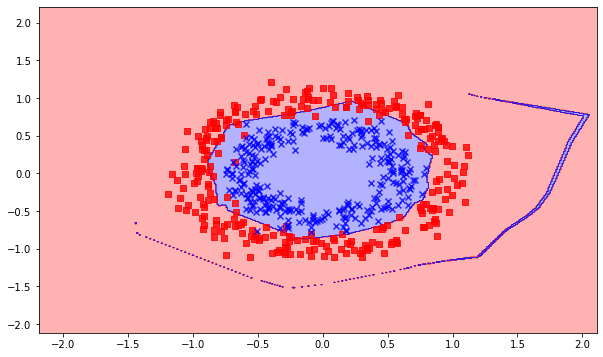

In [99]:
y_test_pred = deepNNPredict(X_test, optimalParameters, activationDict)
testAccuracy = (np.sum(y_test == y_test_pred)/y_test.size)*100
plotDecisionRegions(X_test, y_test, classifier = lambda x : deepNNPredict(x, optimalParameters, activationDict))
print(f'Testing Accuracy:{testAccuracy}')

## vii) Optimization: Minibatch gradient descent + Adam optimization

In [100]:
def adamObjective(trial):
    alpha = trial.suggest_float('alpha',-4,-1)
    beta1 = trial.suggest_float('beta1',0.89,1.)
    beta2 = trial.suggest_float('beta2', 0.95,1.)
    batchSize = trial.suggest_categorical('batchSize',[64,128])
    optimalParameters, costList = deepNNRegularizedFit(X_train, y_train, layerDims = layerDims, activations = activationDict, derivatives = derivativeDict, withDropout = [0]*6, keepProb = 1., learningRate = 10**alpha, epochs = 5000, batchSize = batchSize, beta1 = beta1, beta2 = beta2, epsilon = 1e-8, optimizer = 'adam')
    y_train_pred = deepNNPredict(X_train, optimalParameters,activationDict)
    trainAccuracy = np.sum(y_train_pred == y_train)*(100/y_train.size)
    return trainAccuracy

In [101]:
adamStudy = optuna.create_study(direction = 'maximize')
adamStudy.optimize(adamObjective, n_trials = 50)

[I 2024-04-25 15:17:38,175] A new study created in memory with name: no-name-846f0cc3-1bd4-4c64-a198-c436a25d6c92
C:\Users\user\AppData\Local\Temp/ipykernel_21568/1239813614.py:28: RuntimeWarning: overflow encountered in square
  s['db' + str(i)] = beta2 * s['db' + str(i)] + (1. - beta2) * np.square(gradients['db' + str(i)])
C:\Users\user\AppData\Local\Temp/ipykernel_21568/1239813614.py:27: RuntimeWarning: overflow encountered in square
  s['dW' + str(i)] = beta2 * s['dW' + str(i)] + (1. - beta2) * np.square(gradients['dW' + str(i)])
[I 2024-04-25 15:18:41,228] Trial 0 finished with value: 50.291666666666664 and parameters: {'alpha': -2.0019641819084506, 'beta1': 0.9357685446243503, 'beta2': 0.9760923456435374, 'batchSize': 128}. Best is trial 0 with value: 50.291666666666664.
[I 2024-04-25 15:19:43,570] Trial 1 finished with value: 97.58333333333333 and parameters: {'alpha': -1.7678560264183076, 'beta1': 0.9630964307771964, 'beta2': 0.9560668900798511, 'batchSize': 128}. Best is trial

[I 2024-04-25 15:52:14,054] Trial 29 finished with value: 49.70833333333333 and parameters: {'alpha': -2.2015203155302756, 'beta1': 0.9546080323233872, 'beta2': 0.9588746523136846, 'batchSize': 128}. Best is trial 19 with value: 97.75.
[I 2024-04-25 15:53:10,328] Trial 30 finished with value: 95.29166666666666 and parameters: {'alpha': -2.006215944237884, 'beta1': 0.9426428028780228, 'beta2': 0.9721539166101537, 'batchSize': 128}. Best is trial 19 with value: 97.75.
[I 2024-04-25 15:54:06,419] Trial 31 finished with value: 97.66666666666666 and parameters: {'alpha': -2.4174623651408167, 'beta1': 0.9574994495784858, 'beta2': 0.9529564815007393, 'batchSize': 128}. Best is trial 19 with value: 97.75.
[I 2024-04-25 15:55:02,726] Trial 32 finished with value: 49.70833333333333 and parameters: {'alpha': -2.3865105087699203, 'beta1': 0.9601043490998153, 'beta2': 0.9557782452848478, 'batchSize': 128}. Best is trial 19 with value: 97.75.
[I 2024-04-25 15:55:59,089] Trial 33 finished with value:

### Train set

By trial 1, an accuracy of 97.58 had been obtained. By trial 19, an accuracy of 97.75 was obtained!!

In [102]:
adamStudy.best_params

{'alpha': -2.3857170224659563,
 'beta1': 0.940388690208802,
 'beta2': 0.9750804959877424,
 'batchSize': 128}

Train set Accuracy:97.75


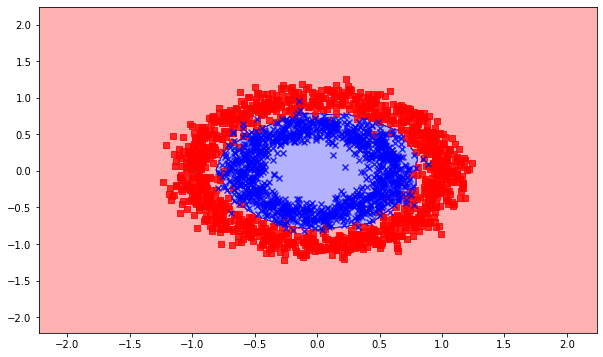

In [104]:
optimalAlpha = -2.3857170224659563
optimalBeta1 = 0.940388690208802
optimalBeta2 = 0.9750804959877424
optimalBatchSize = 128
optimalParameters, costList = deepNNRegularizedFit(X_train, y_train, layerDims = layerDims, activations = activationDict, derivatives = derivativeDict, withDropout = [0]*6, keepProb = 1., learningRate = 10**optimalAlpha, epochs = 5000, batchSize = optimalBatchSize, beta1 = optimalBeta1, beta2 = optimalBeta2, epsilon = 1e-8, optimizer = 'adam')
y_train_pred = deepNNPredict(X_train, optimalParameters,activationDict)
trainAccuracy = np.sum(y_train_pred == y_train)*(100/y_train.size)
plotDecisionRegions(X_train, y_train, classifier = lambda x : deepNNPredict(x, optimalParameters, activationDict))
print(f'Train set Accuracy:{trainAccuracy}')

### Test set

Testing Accuracy:97.66666666666667


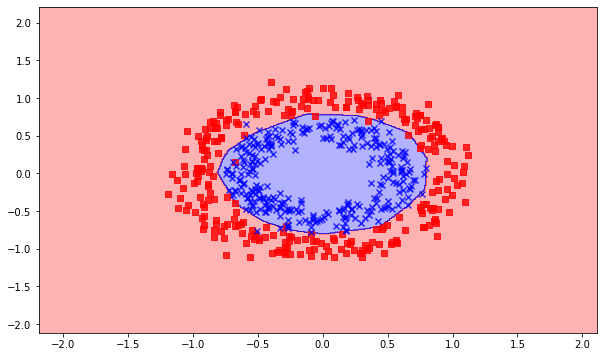

In [105]:
y_test_pred = deepNNPredict(X_test, optimalParameters, activationDict)
testAccuracy = (np.sum(y_test == y_test_pred)/y_test.size)*100
plotDecisionRegions(X_test, y_test, classifier = lambda x : deepNNPredict(x, optimalParameters, activationDict))
print(f'Testing Accuracy:{testAccuracy}')

## Summary of Results for the different Regularization and Optimization Techniques

   |Regularization/Optimization Technique | Test Set Accuracy|
   |--------------------------------------|------------------|
   |Batch Gradient Descent| 70.17%|
   |Batch Gradient Descent with L2 Regularization | 76.67%|
   |Batch Gradient Descent with Dropout Regularization | 77.17%|
   |Minibatch Gradient Descent| 86.83%|
   |Minibatch Gradient Descent with Momentum |95.17%|
   |Minibatch Gradient Descent with Adam optimization| 97.67%|


` -L2 Regularization and Dropout regularization help address overfitting problems when using batch gradient descent.`

`- There was a significant increase in accuracy after shifting from batch gradient descent to minibatch gradient descent and another significant increase in accuracy when applying Momentum and Adam optimization techniques with minibatch gradient descent `